<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/24-keras-part-2/1_improving_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving the Model

We’ve explored a lot of the features Keras offers using our tiny 2-layer
model. As we just saw, after only about 20 epochs of training this
model was able to accurately classify about 98% of the images in the
MNIST test set.

Though sometimes a change to our model can bring about a big
improvement in accuracy, much of the time improving a model’s performance
is a game of accumulating a sequence of tiny improvements.

## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical

keras_backend.set_image_data_format('channels_last')

TensorFlow 2.x selected.


## Load and process the MNIST data

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()

image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width


# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)


# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0


# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test)).astype(np.int32)

# encode each list into one-hot arrays of the size we just found
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape samples to 2D grid, one line per image
X_train = X_train.reshape([X_train.shape[0], number_of_pixels])
X_test = X_test.reshape([X_test.shape[0], number_of_pixels])

11493376/11490434 [==============================] - 0s 0us/step


## Make one hidden layer model

In [4]:
# These variables are assigned during our pre-processing step. 
# We'll just assign them directly here for this demonstration.
number_of_pixels = 28*28  # size of an MNIST image
number_of_classes = 10    # MNIST images are digits 0 to 9

def make_one_hidden_layer_model():

  # create an empty model
  model = Sequential()

  # add a fully-connected hidden layer with #nodes = #pixels
  model.add(Dense(number_of_pixels, activation='relu', input_shape=[number_of_pixels]))

  # add an output layer with softmax activation
  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model to turn it from specification to code
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# train the model
model = make_one_hidden_layer_model()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=256, verbose=2)  

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 - 3s - loss: 0.2964 - accuracy: 0.9175 - val_loss: 0.1667 - val_accuracy: 0.9509
Epoch 2/20
60000/60000 - 1s - loss: 0.1225 - accuracy: 0.9650 - val_loss: 0.1087 - val_accuracy: 0.9665
Epoch 3/20
60000/60000 - 1s - loss: 0.0791 - accuracy: 0.9773 - val_loss: 0.0803 - val_accuracy: 0.9774
Epoch 4/20
60000/60000 - 1s - loss: 0.0569 - accuracy: 0.9836 - val_loss: 0.0736 - val_accuracy: 0.9771
Epoch 5/20
60000/60000 - 1s - loss: 0.0444 - accuracy: 0.9870 - val_loss: 0.0747 - val_accuracy: 0.9768
Epoch 6/20
60000/60000 - 1s - loss: 0.0324 - accuracy: 0.9910 - val_loss: 0.0641 - val_accuracy: 0.9797
Epoch 7/20
60000/60000 - 1s - loss: 0.0240 - accuracy: 0.9939 - val_loss: 0.0592 - val_accuracy: 0.9810
Epoch 8/20
60000/60000 - 1s - loss: 0.0178 - accuracy: 0.9961 - val_loss: 0.0617 - val_accuracy: 0.9816
Epoch 9/20
60000/60000 - 1s - loss: 0.0148 - accuracy: 0.9965 - val_loss: 0.0614 - val_accuracy: 0.9804
Epoch 10/20
60

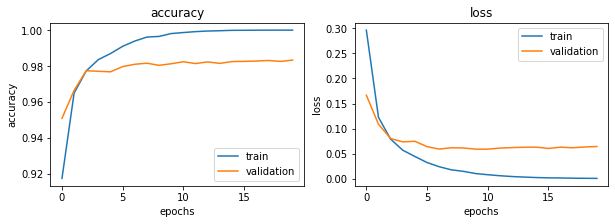

In [5]:
xs = range(len(history.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history.history['accuracy'], label='train')
plt.plot(xs, history.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history.history['loss'], label='train')
plt.plot(xs, history.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss')

plt.show()

## Changing One Hyperparameter

A frequent rule in experimentation of all sorts is to change only one
thing at a time and see what happens. This is a good plan if the values
involved are largely decoupled, meaning that they don’t affect one another.

Unfortunately, the hyperparameters of most real systems, and most
deep-learning systems, are not decoupled. If we increase the amount
of hyperparameter A and find things get better, and then increase
the amount of hyperparameter B, we may find that we now have to
decrease the value in A to make further progress. The connections are
complex.

But still, changing one hyperparameter at a time is usually a good way
to start. We can explore what that value does, find a good value for it,
and then choose another hyperparameter to adjust, and so on, searching
for a good combination by fine-tuning one hyperparameter at a
time.

Let’s try that now, arbitrarily picking the batch size as our first hyperparameter
to experiment with.

In [0]:
# A little utility to draw accuracy and loss plots
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['accuracy']))
    # manually change legend location to 'best' when the locations
    # here don't look good. 

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    plt.show()

In [0]:
# A utility to let us try out lots of variations of models,
# batch size, and early stopping, and plot and save the results.
#
# We use Python's kwargs mechanism is a way to package up the parameters
# to a function in a dictionary. It's a little fancy but it saves a huge
# amount of code. See the Python docs for how this feature works.
#   

random_seed = 42

def run_and_report(model, plot_title=None, filename='generic-filename', 
                   epochs=100, batch_size=256, verbosity=2, stop_early=False):
    np.random.seed(random_seed)
    kwargs = { 'validation_data': (X_test, y_test), 'epochs': epochs,
              'batch_size': batch_size, 'verbose': verbosity }
    if stop_early:
        early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        kwargs['callbacks'] = [early_stopper]
    history = model.fit(X_train, y_train, **kwargs)
    plot_accuracy_and_loss(history, plot_title, filename)
    #models_folder_name = 'NB09-checkpointed-models'
    #file_helper.check_for_directory(models_folder_name)

    #filename = models_folder_name+'/'+filename+'-'+str(epochs)+'-epochs.h5'
    #model.save(filename)
    return history

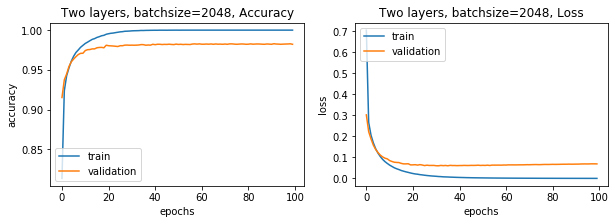

batchsize  2048  elapsed time= 33.26907014846802


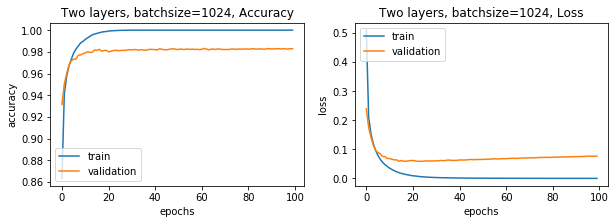

batchsize  1024  elapsed time= 49.7650580406189


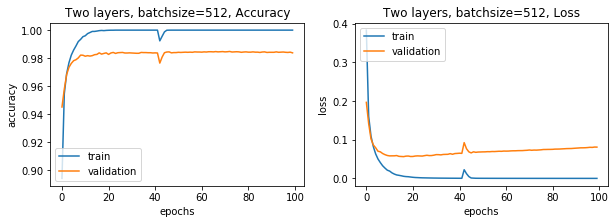

batchsize  512  elapsed time= 73.5817289352417


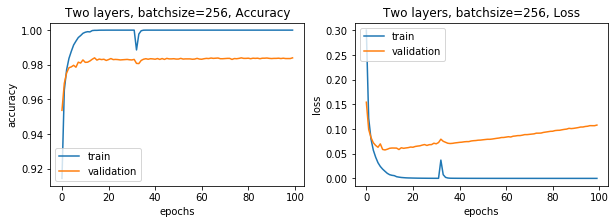

batchsize  256  elapsed time= 124.68649220466614


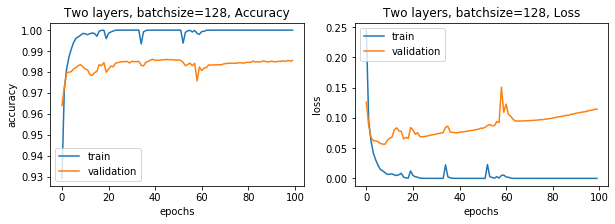

batchsize  128  elapsed time= 220.88846015930176


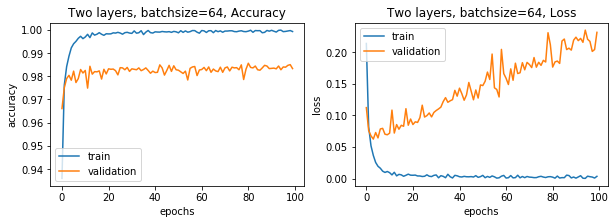

batchsize  64  elapsed time= 396.67887234687805


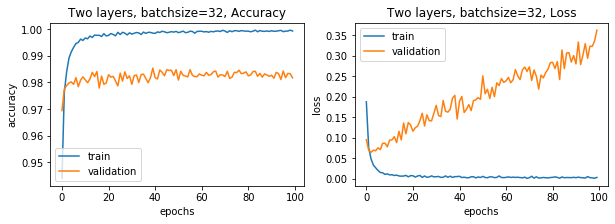

batchsize  32  elapsed time= 771.392050743103


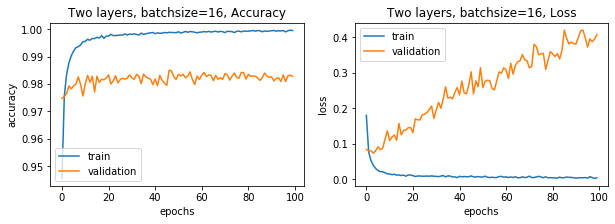

batchsize  16  elapsed time= 1534.0759272575378


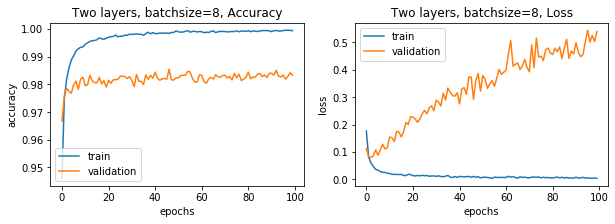

batchsize  8  elapsed time= 2960.397512435913


In [13]:
#
# WARNING: As batch sizes decrease, running time increases FAST.
# Without a GPU, be careful with batch sizes smaller than 256.
#
import time
history_list = []
time_list = []
for batchsize in [2048, 1024, 512, 256, 128, 64, 32, 16, 8]:
    model = make_one_hidden_layer_model()
    plot_title = 'Two layers, batchsize='+str(batchsize)
    filename = 'two-layers-batch-'+str(batchsize)
    start_time = time.time()
    history = run_and_report(model, plot_title, filename, batch_size=batchsize, verbosity=0)
    end_time = time.time()
    elapsed_time = end_time-start_time
    history_list.append(history)
    print("batchsize ",batchsize," elapsed time=",elapsed_time)
    time_list.append(elapsed_time)

In [0]:
# run it one-by-one if GPU is not avaialbale
plot_accuracy_and_loss(history_list[0], 'Two layers, batchsize=2048', 'two-layers-batch-2048')
plot_accuracy_and_loss(history_list[1], 'Two layers, batchsize=1024', 'two-layers-batch-1024')
plot_accuracy_and_loss(history_list[2], 'Two layers, batchsize=512', 'two-layers-batch-512')
plot_accuracy_and_loss(history_list[3], 'Two layers, batchsize=256', 'two-layers-batch-256')
plot_accuracy_and_loss(history_list[4], 'Two layers, batchsize=128', 'two-layers-batch-128')
plot_accuracy_and_loss(history_list[5], 'Two layers, batchsize=64', 'two-layers-batch-64')
plot_accuracy_and_loss(history_list[6], 'Two layers, batchsize=32', 'two-layers-batch-32')
plot_accuracy_and_loss(history_list[7], 'Two layers, batchsize=16', 'two-layers-batch-16')
plot_accuracy_and_loss(history_list[8], 'Two layers, batchsize=8', 'two-layers-batch-8')

Three things jump out from these figures.

* First, as the batch size gets smaller, the results get more jittery, or noisy.
This is because each new update is working with fewer samples, so it’s
responding to whatever happens to be in that batch. Larger batches
tend to become more representative of the dataset as a whole, and give
us smoother results. Smaller batches give us a lot of jumping around.
* The second thing is that the training accuracy is about 98% on all the
models, so the batch size didn’t affect that accuracy very much.
* The third thing is that although all of the models are overfitting, as
demonstrated by the diverging training and validation losses, as the
batch size gets smaller the divergence of the training and validation
error increases. In other words, the amount of overfitting increases.

Smaller batches mean that epochs take longer, because we need to
perform backprop and update the weights more frequently.

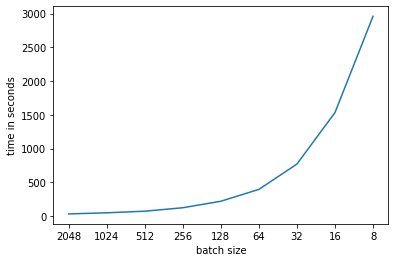

In [14]:
plt.plot(range(len(time_list)), time_list)
plt.xlabel('batch size')
plt.ylabel('time in seconds')
plt.xticks(range(len(time_list)), [2048, 1024, 512, 256, 128, 64, 32, 16, 8])
plt.show()

The curve in figure confirms that on these CPU-only runs, as the
batch size went down, we’re running more backprop and update steps,
so the total training time went up.

## Adding Another Dense Layer